In [96]:
import pandas as pd
import csv 
import geopandas as gpd
from datetime import timedelta
from shapely.geometry import Point
from shapely import wkt
import glob
import matplotlib.pyplot as plt

In [187]:
#read csv files and adjust to datetime
C_im_date = pd.read_csv('../data/Cienega/CienegaImageryDates.csv', parse_dates=['date'])
C_sur_date = pd.read_csv('../data/Cienega/Cienega_survey_dates.csv', parse_dates=['Cienega date'])
C_sur_date['Cienega date'] = pd.to_datetime(C_sur_date['Cienega date'])
C_im_date['date'] = pd.to_datetime(C_im_date['date'])

C_hyd = pd.read_csv('../data/Cienega/CienegaHydroData.csv')
C_hyd['datetime'] = pd.to_datetime(C_hyd['datetime'])

C_precipitation = pd.read_csv('../data/Cienega/daymet_precip.csv')
C_precipitation['system:time_start'] = pd.to_datetime(C_precipitation['system:time_start'])
C_precipitation.rename( columns={'00000000000000000000':'P','system:time_start':'day'}, inplace=True )

C_sur_date = C_sur_date.dropna(subset=['Cienega date'])
C_im_date = C_im_date.dropna(subset=['date'])

C_surveyData = pd.read_csv('../data/Cienega/Cienega_surveyData.csv')
# C_surveyData['Year'] = pd.to_datetime(C_surveyData['Year'])


In [188]:
C_surveyData.Year.unique()

array(['12-9-2015', '3-13-2015', '6-16-2015', '9-16-2015', '6-3-2016',
       '9-23-2016', '12-16-2016', '3-18-2016', '6-9-2017', '9-19-2017',
       '12-8-2017', '3-16-2017', '6-5-2018', '9-8-2018', '12-17-2018',
       '3-23-2018', '6-7-2019', '9-13-2019', '12-13-2019', '3-26-2019',
       '6-12-2020', '9-17-2020', '12-18-2020', '3-24-2020', '6-9-2021',
       '9-10-2021', '12-13-2021', '3-19-2021', '12-15-2022', '3-18-2022',
       '6-3-2022', '9-8-2022', '3-10-2023', '6-8-2023'], dtype=object)

In [189]:
#finding closest matching dates between survey and imagery
matching_dates = []
tolerance = timedelta(days = 5)


for date1 in C_sur_date['Cienega date']:
    exact_date = False
    tol = False 
    for date2 in C_im_date['date']:
        if date1 == date2:
            matching_dates.append({'Survey': date1, 'Imagery': date2})
            exact_date = True
    if not exact_date:
        for date2 in C_im_date['date']:
            if abs(date1 - date2) <= tolerance:
                matching_dates.append({'Survey': date1, 'Imagery': date2})
                tol = True
        if not tol:
            for date2 in C_im_date['date']:
                if abs(date1-date2) < timedelta(days = 10): 
                    matching_dates.append({'Survey': date1, 'Imagery': date2})


matching_dates_df = pd.DataFrame(matching_dates)



In [190]:
#merging dfs to use to determine imagery dates for survey dates
C_datessurData = pd.merge(matching_dates_df, C_hyd, left_on = 'Survey', right_on = 'datetime', how = 'left')
C_datesimData = pd.merge(matching_dates_df, C_hyd, left_on = 'Imagery', right_on = 'datetime')
C_datessurData = C_datessurData.drop(columns = ['Imagery','datetime'])
C_datesimData = C_datesimData.drop(columns = ['Survey','datetime'])

In [191]:
#sum precipitation for dates in between survey and imagery
def sum_pdatesbetween(d1, d2):
    r = pd.date_range(start=min(d1,d2), end=max(d1,d2))
    return C_hyd[C_hyd['datetime'].isin(r)]['P [mm]'].sum()

In [192]:
#making a dataframe to determine which imagery dates to use
Ch = pd.DataFrame([])

Ch['Survey'] = matching_dates_df['Survey']
Ch['Imagery'] = matching_dates_df['Imagery']
Ch['sum_P'] = [sum_pdatesbetween(C_datessurData.loc[i, 'Survey'], C_datesimData.loc[i, 'Imagery']) for i in range(len(Ch))]
Ch['Q_diff [%]'] = (C_datessurData['Q [mm/d]'] - C_datesimData['Q [mm/d]']) / C_datessurData['Q [mm/d]'] * 100
Ch['Use/not'] = ['use', 'use', 'use', 'use', 'not', 'not', 'use?',
                 'not', 'only option', 'not', 'not', 'use', 'not',
                 'not', 'not', 'use', 'not', 'not', 'not', 'not',
                 'use', 'use', 'use', 'only option','use', 'use', 
                 'use','use', 'not', 'not', 'not', 'not', 'use', 
                 'not', 'use', 'use', 'use', 'use', 'use', 'not', 
                 'not', 'not', 'not', 'use', 'not', 'not', 'not', 
                 'not', 'not', 'use', 'not', 'not', 'not', 'use', 
                 'not', 'use', 'use']


# conditions = (Ch['sum_P'] > 3) | (Ch['Q_diff [%]'] > 8) | (Ch['Use/not'] == 'not')

# Ch = Ch[~conditions]

Ch = Ch[(Ch['Use/not']=='use')&(Ch.sum_P<3)&(Ch['Q_diff [%]']<8)]

Ch = Ch.drop(columns=['Use/not'])


In [193]:
Ch.to_csv('../data/Cienega/Cienega_survey_imagery_HydroData.csv', encoding='utf-8', index=False)

In [194]:
#reading surveydata, making it into a geodataframe and adding x and y from the geometry to facilitate merge later 
C_surveyData['geometry'] = C_surveyData['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(C_surveyData, geometry = 'geometry', crs='EPSG:26912')
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
gdf = gdf[['geometry', 'x', 'y', 'wetdry', 'Year']]
gdf['Year'] = pd.to_datetime(gdf['Year'])


In [195]:
C_surveyData.Year.unique()

array(['12-9-2015', '3-13-2015', '6-16-2015', '9-16-2015', '6-3-2016',
       '9-23-2016', '12-16-2016', '3-18-2016', '6-9-2017', '9-19-2017',
       '12-8-2017', '3-16-2017', '6-5-2018', '9-8-2018', '12-17-2018',
       '3-23-2018', '6-7-2019', '9-13-2019', '12-13-2019', '3-26-2019',
       '6-12-2020', '9-17-2020', '12-18-2020', '3-24-2020', '6-9-2021',
       '9-10-2021', '12-13-2021', '3-19-2021', '12-15-2022', '3-18-2022',
       '6-3-2022', '9-8-2022', '3-10-2023', '6-8-2023'], dtype=object)

In [196]:
# using new data for precipitation 
C_new_hyd = C_hyd.merge(C_precipitation, left_on = 'datetime', right_on = 'day')
C_new_hyd = C_new_hyd.drop(columns = ['day', 'P [mm]'])
C_new_hyd.rename( columns={'P':'P [mm]'}, inplace=True )
C_new_hyd.set_index(['datetime'], inplace = True)

In [197]:
# function to define assumptions around dates to choose, based on streamflow and precipitation
# Q_condition could be completely removed
def tolerance(Q_P_data, date, start, adjust, tolerance_p, P_condition = -999, Q_condition = -999):
    
    sub_grupp = Q_P_data.copy()
    
    if adjust == 'start':      
        sub_grupp = Q_P_data.loc[start:].copy()       
        
    elif adjust == 'end': #reverse index to loop backwards
        sub_grupp = sub_grupp.loc[:start].copy().iloc[::-1]        
    
    else:
        print('Invalid adjust parameter. Please use "start" or "end"')
        return

    
    # Reset index if reversed
    sub_grupp.reset_index(inplace=True)

    #creating a column for difference in streamflow
    sub_grupp['Q_diff'] = sub_grupp['Q [mm/d]'].diff().fillna(0)

    #checking to see if streamflow is overall decreasing, but a tolerance of x for any daily increase
    if adjust == 'start':
        sub_grupp['tolerance_condition'] = (sub_grupp.Q_diff < tolerance_p * sub_grupp['Q [mm/d]'])

    if adjust == 'end':
        sub_grupp['tolerance_condition'] = (sub_grupp.Q_diff > -tolerance_p * sub_grupp['Q [mm/d]'])

    
    if P_condition == -999 == Q_condition:
        print('not a valid condition')
        return 
        
    elif P_condition == -999:
        if Q_condition > 0:
            sub_grupp['condition'] = sub_grupp['Q [mm/d]'] > Q_condition
        else:
            sub_grupp['condition'] = sub_grupp['Q [mm/d]'] < -Q_condition
            
    elif Q_condition == -999:
        if P_condition > 0:
            sub_grupp['condition'] = sub_grupp['P [mm]'] > P_condition
        else:
            sub_grupp['condition'] = sub_grupp['P [mm]'] < -P_condition
            
    else:
        if (Q_condition > 0) & (P_condition > 0):
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] > Q_condition) & (sub_grupp['P [mm]'] > P_condition)
        elif (Q_condition < 0) & (P_condition > 0):
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] < -Q_condition) & (sub_grupp['P [mm]'] > P_condition)           
        elif (Q_condition > 0) & (P_condition < 0):
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] > Q_condition) & (sub_grupp['P [mm]'] < -P_condition)            
        else:
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] < -Q_condition) & (sub_grupp['P [mm]'] < -P_condition)

    # where both conditions are true
    yesgroup = sub_grupp[(sub_grupp['condition'] == True) & (sub_grupp['tolerance_condition'] == True)] 
       
    
    if len(yesgroup) == 0:
        print('No data where conditions are met')
        return pd.DataFrame()

    #the first instance where conditions are false after conditions hev been met 
    nogroup = sub_grupp[(sub_grupp['condition'] == False) | (sub_grupp['tolerance_condition'] == False)]  
    
    if len(nogroup) == 0:
        print('nogroup = 0')
        return sub_grupp.loc[yesgroup.index[0]:]

    if yesgroup.index[0] < nogroup.index[0]:
        print('everything is fine')
        return sub_grupp.loc[:nogroup.index[0]]
    
    else:
        print('No valid range found between yesgroup and nogroup indices')
        return pd.DataFrame()



In [203]:
# assuming perennial reaches
perennial = pd.DataFrame(gdf[gdf.wetdry=='wet'].groupby('geometry').wetdry.count()).reset_index()#pd.DataFrame(gdf.groupby('geometry')['wetdry'].apply(lambda x: sum(x == 'wet'))).reset_index(drop=False)
perennialcount = pd.DataFrame(gdf.groupby('geometry')['wetdry'].count()).reset_index(drop=False)

# whichever number is reasonable based on data?
perennial = perennial[(perennial['wetdry'] >= (perennialcount['wetdry']-2))]

#assume always wet
perennial = perennial.assign(wetdry = 'wet')

#perennial['geometry'] = perennial['geometry'].apply(wkt.loads)
gdf_perennial = gpd.GeoDataFrame(perennial, geometry = 'geometry', crs='EPSG:26912')
gdf_perennial['x'] = gdf_perennial.geometry.x
gdf_perennial['y'] = gdf_perennial.geometry.y

#making the gdf matching the perennial reaches to all the imagery dates available 
imagery_perennial = pd.concat([gdf_perennial.assign(imagery = date) for date in C_im_date['date']], ignore_index=True)
imagery_perennial = imagery_perennial[~imagery_perennial['imagery'].isin(Ch['Imagery'])]
imagery_perennial['assumption'] = len(imagery_perennial)*['assumed perennial']
imagery_perennial 

,geometry,wetdry,x,y,imagery,assumption
188,POINT (535062.293 3541975.229),wet,535062.292569,3.541975e+06,2016-11-17,assumed perennial
189,POINT (535058.14 3541978.014),wet,535058.140119,3.541978e+06,2016-11-17,assumed perennial
190,POINT (535053.988 3541980.799),wet,535053.987669,3.541981e+06,2016-11-17,assumed perennial
191,POINT (535037.378 3541991.94),wet,535037.377869,3.541992e+06,2016-11-17,assumed perennial
192,POINT (535045.683 3541986.369),wet,535045.682769,3.541986e+06,2016-11-17,assumed perennial
...,...,...,...,...,...,...
169383,POINT (535828.567 3541960.917),wet,535828.567326,3.541961e+06,2024-04-15,assumed perennial
169384,POINT (535819.949 3541955.845),wet,535819.949062,3.541956e+06,2024-04-15,assumed perennial
169385,POINT (535815.64 3541953.309),wet,535815.639930,3.541953e+06,2024-04-15,assumed perennial
169386,POINT (535811.331 3541950.773),wet,535811.330798,3.541951e+06,2024-04-15,assumed perennial


In [204]:
perennialcount
len(perennial),len(gdf.groupby('geometry').first())

(188, 2641)

In [208]:
#assuming wet stretches for the dates before
#assumption is made with 5 % difference in streamflow and for dates before survey when in a recession 

wet_list = []

for date in C_surveyData['Year'].unique():
            
    wet1 = tolerance(C_new_hyd, 'datetime', date, 'end', 0.05, Q_condition = -999, P_condition = -1)
    if len(wet1) == 0:
        print('wet1 is empty')
        continue
    wet1 = wet1[~wet1['datetime'].isin(Ch['Imagery'])]
    wet_imagery = pd.merge(wet1, C_im_date, left_on = ['datetime'], right_on = ['date'], how = 'inner')
    #print(len(wet_imagery))
    wet_points = pd.DataFrame(gdf[gdf['Year']== (date)].groupby('geometry')['wetdry'].apply(lambda x: sum(x == 'wet'))).reset_index(drop = False)
    wet_points = wet_points[(wet_points['wetdry'] == 1)]
    wet_points = wet_points.assign(wetdry = 'wet')
    wet_im_points = [wet_points.assign(imagery = date) for date in wet_imagery['date']]
        
    try:
        wet = pd.concat(wet_im_points).drop(columns = ['level_1'])
        wet_list.append(wet)
    except:
        if len(wet_im_points)==0:
            print('No data for date '+ pd.to_datetime(date).strftime('%Y-%m-%d'))
        else:
            wet = wet_im_points[0]
            wet_list.append(wet)
        

wet_df = pd.concat(wet_list)


wet_df['assumption'] = len(wet_df)*['assumed wet']




No data where conditions are met
wet1 is empty
No data where conditions are met
wet1 is empty
No data where conditions are met
wet1 is empty
No data where conditions are met
wet1 is empty
everything is fine
No data for date 2016-06-03
everything is fine
No data for date 2016-09-23
No valid range found between yesgroup and nogroup indices
wet1 is empty
everything is fine
No data for date 2016-03-18
everything is fine
No data for date 2017-06-09
everything is fine
No data for date 2017-09-19
everything is fine
everything is fine
No data for date 2017-03-16
everything is fine
No data for date 2018-06-05
everything is fine
No valid range found between yesgroup and nogroup indices
wet1 is empty
everything is fine
No data for date 2018-03-23
everything is fine
everything is fine
No data for date 2019-09-13
everything is fine
everything is fine
everything is fine
everything is fine
No data for date 2020-09-17
everything is fine
everything is fine
everything is fine
everything is fine
No valid

In [210]:
#assuming dry stretches for the dates after
#assumption is made with 5 % difference in streamflow and for dates after survey when in a recession 

dry_list = []


for date in C_surveyData['Year'].unique():
            
    dry1 = tolerance(C_new_hyd, 'datetime', date, 'start', 0.05, Q_condition = -999, P_condition = -1)
    if len(dry1) == 0:
        print('wet1 is empty')
        continue
    dry1 = dry1[~dry1['datetime'].isin(Ch['Imagery'])]
    dry_imagery = pd.merge(dry1, C_im_date, left_on = ['datetime'], right_on = ['date'], how = 'inner')
        #print(len(wet_imagery))
    dry_points = pd.DataFrame(gdf[gdf['Year']== (date)].groupby('geometry')['wetdry'].apply(lambda x: sum(x == 'dry'))).reset_index(drop = False)
    dry_points = dry_points[(dry_points['wetdry'] == 1)].assign(wetdry = 'dry')
    dry_im_points = [dry_points.assign(imagery = date) for date in dry_imagery['date']]
        
    try:
        dry = pd.concat(dry_im_points).drop(columns = ['level_1'])
        dry_list.append(dry)
        
    except:
        if len(dry_im_points)==0:
            print('No data for date '+ pd.to_datetime(date).strftime('%Y-%m-%d'))
        else:
            dry = dry_im_points[0]
            dry_list.append(dry)
        #print(len(dry))
        

dry_df = pd.concat(dry_list)

dry_df['assumption'] = len(dry_df)*['assumed dry']





everything is fine
No data for date 2015-12-09
everything is fine
No data for date 2015-03-13
everything is fine
No data for date 2015-06-16
everything is fine
No data for date 2015-09-16
everything is fine
No data for date 2016-06-03
everything is fine
No data for date 2016-09-23
No valid range found between yesgroup and nogroup indices
wet1 is empty
everything is fine
No data for date 2016-03-18
everything is fine
No data for date 2017-06-09
everything is fine
everything is fine
everything is fine
No data for date 2017-03-16
everything is fine
everything is fine
No valid range found between yesgroup and nogroup indices
wet1 is empty
everything is fine
No data for date 2018-03-23
everything is fine
everything is fine
No data for date 2019-09-13
everything is fine
everything is fine
everything is fine
everything is fine
everything is fine
everything is fine
everything is fine
everything is fine
No valid range found between yesgroup and nogroup indices
wet1 is empty
everything is fine
e

In [211]:
gdf.Year.unique()

<DatetimeArray>
['2015-12-09 00:00:00', '2015-03-13 00:00:00', '2015-06-16 00:00:00',
 '2015-09-16 00:00:00', '2016-06-03 00:00:00', '2016-09-23 00:00:00',
 '2016-12-16 00:00:00', '2016-03-18 00:00:00', '2017-06-09 00:00:00',
 '2017-09-19 00:00:00', '2017-12-08 00:00:00', '2017-03-16 00:00:00',
 '2018-06-05 00:00:00', '2018-09-08 00:00:00', '2018-12-17 00:00:00',
 '2018-03-23 00:00:00', '2019-06-07 00:00:00', '2019-09-13 00:00:00',
 '2019-12-13 00:00:00', '2019-03-26 00:00:00', '2020-06-12 00:00:00',
 '2020-09-17 00:00:00', '2020-12-18 00:00:00', '2020-03-24 00:00:00',
 '2021-06-09 00:00:00', '2021-09-10 00:00:00', '2021-12-13 00:00:00',
 '2021-03-19 00:00:00', '2022-12-15 00:00:00', '2022-03-18 00:00:00',
 '2022-06-03 00:00:00', '2022-09-08 00:00:00', '2023-03-10 00:00:00',
 '2023-06-08 00:00:00']
Length: 34, dtype: datetime64[ns]

In [212]:
# concatenate all dfs with assumptions and survey matched to imagery dates and turn to gdf
gdf['assumption'] = len(gdf)*['survey/imagery match']
gdf_imagery = gdf.merge(Ch, left_on = 'Year', right_on = 'Survey', how = 'left')
gdf_imagery = gdf_imagery.drop(columns=['Survey', 'sum_P', 'Q_diff [%]', 'Year'])
all_expanded = pd.concat([gdf_imagery, imagery_perennial, wet_df, dry_df])
all_expanded = gpd.GeoDataFrame(all_expanded, geometry = 'geometry', crs='EPSG:26912')
all_expanded['x'] = all_expanded.geometry.x
all_expanded['y'] = all_expanded.geometry.y
all_expanded = all_expanded.rename(columns = {'imagery':'date_first'})
all_expanded['date'] = all_expanded['Imagery'].combine_first(all_expanded['date_first'])
all_expanded

,geometry,x,y,wetdry,assumption,Imagery,date_first,date
0,POINT (533719.252 3542427.373),533719.252411,3.542427e+06,dry,survey/imagery match,NaT,NaT,NaT
1,POINT (533719.787 3542422.402),533719.786671,3.542422e+06,dry,survey/imagery match,NaT,NaT,NaT
2,POINT (533720.321 3542417.431),533720.320931,3.542417e+06,dry,survey/imagery match,NaT,NaT,NaT
3,POINT (533720.855 3542412.459),533720.855191,3.542412e+06,dry,survey/imagery match,NaT,NaT,NaT
4,POINT (533721.389 3542407.488),533721.389451,3.542407e+06,dry,survey/imagery match,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...
2592,POINT (539654.459 3540292.383),539654.459252,3.540292e+06,dry,assumed dry,NaT,2023-06-11,2023-06-11
2593,POINT (539659.459 3540292.405),539659.459205,3.540292e+06,dry,assumed dry,NaT,2023-06-11,2023-06-11
2594,POINT (539664.459 3540292.426),539664.459158,3.540292e+06,dry,assumed dry,NaT,2023-06-11,2023-06-11
2595,POINT (539670.938 3540292.749),539670.938285,3.540293e+06,dry,assumed dry,NaT,2023-06-11,2023-06-11


In [213]:
all_expanded[all_expanded.assumption=='survey/imagery match'].date.unique()

<DatetimeArray>
[                'NaT', '2016-09-22 00:00:00', '2017-06-09 00:00:00',
 '2017-09-21 00:00:00', '2017-03-13 00:00:00', '2018-06-04 00:00:00',
 '2018-09-07 00:00:00', '2018-12-17 00:00:00', '2019-06-07 00:00:00',
 '2019-12-13 00:00:00', '2019-03-26 00:00:00', '2020-06-12 00:00:00',
 '2020-09-17 00:00:00', '2020-12-19 00:00:00', '2020-03-24 00:00:00',
 '2021-06-09 00:00:00', '2021-09-10 00:00:00', '2021-12-13 00:00:00',
 '2021-03-19 00:00:00', '2022-12-17 00:00:00', '2022-03-18 00:00:00',
 '2022-06-02 00:00:00', '2022-09-07 00:00:00', '2023-03-10 00:00:00',
 '2023-06-08 00:00:00']
Length: 25, dtype: datetime64[ns]

In [214]:
#reading and concatenating the processed imagery 
path = '../data/Cienega/processed_imagery'

processed_imagery = glob.glob(path + '/*.csv')
processed_imagery.sort(key = lambda x: int(x.split('_buffer_')[1].split('.')[0]))
con_ready_imagery = []
for processed in processed_imagery:
    df= pd.read_csv(processed)
    con_ready_imagery.append(df)

concatenated = pd.concat(con_ready_imagery)

In [215]:
concatenated['geometry'] = concatenated['geometry'].apply(wkt.loads)
gdf_processed = gpd.GeoDataFrame(concatenated, geometry = 'geometry', crs='EPSG:26912')
gdf_processed['date'] = pd.to_datetime(gdf_processed['date'], format='%Y%m%d')
gdf_processed['x'] = gdf_processed.geometry.x
gdf_processed['y'] = gdf_processed.geometry.y

In [216]:
gdf_processed = gdf_processed.drop_duplicates()
gdf_processed.dropna(inplace=True)
gdf_processed = gdf_processed.groupby(['x','y','date']).first().reset_index()

In [217]:
precision = 6
all_expanded['x'] = all_expanded['x'].round(precision)
all_expanded['y'] = all_expanded['y'].round(precision)
gdf_processed['x'] = gdf_processed['x'].round(precision)
gdf_processed['y'] = gdf_processed['y'].round(precision)

In [218]:
merged = all_expanded.merge(gdf_processed, on=['date', 'x', 'y'])

In [219]:
merged = merged.drop(columns = ['geometry_x', 'geometry_y', 'Imagery', 'date_first']) 
merged_sorted = merged.sort_values(by='date')

In [220]:
merged_sorted = merged_sorted.drop_duplicates()
merged_sorted.dropna(inplace= True)
merged_sorted

,x,y,wetdry,assumption,date,blue,green,red,NIR,missing,NDWI,p
0,533719.252411,3.542427e+06,dry,survey/imagery match,2016-09-22,738.67,1076.44,1386.89,2782.33,0,-0.44,0
1758,534431.929623,3.542234e+06,dry,survey/imagery match,2016-09-22,925.44,1216.89,1619.89,2785.00,0,-0.39,0
1759,534436.929596,3.542234e+06,dry,survey/imagery match,2016-09-22,997.56,1270.00,1691.44,2742.11,0,-0.37,0
1760,534441.929569,3.542234e+06,dry,survey/imagery match,2016-09-22,1073.56,1343.22,1780.00,2792.22,0,-0.35,0
1761,534446.929543,3.542234e+06,dry,survey/imagery match,2016-09-22,1089.56,1368.11,1801.33,2846.22,0,-0.35,0
...,...,...,...,...,...,...,...,...,...,...,...,...
226144,535185.391133,3.541955e+06,wet,assumed perennial,2024-04-15,351.89,664.78,658.78,2550.89,0,-0.59,0
226145,535180.450213,3.541956e+06,wet,assumed perennial,2024-04-15,393.56,703.00,740.89,2541.22,0,-0.57,0
226146,535210.095732,3.541951e+06,wet,assumed perennial,2024-04-15,367.22,685.78,710.00,2651.67,0,-0.59,0
226137,535126.100095,3.541964e+06,wet,assumed perennial,2024-04-15,394.78,711.89,672.11,2368.00,0,-0.54,0


In [221]:
start = 0
splitnum = 10
for i in range(1,splitnum+1):
    newstart = int(len(merged_sorted)/splitnum*i)
    merged_sorted.iloc[start:newstart].to_csv('../data/Cienega/processed_assumptions/processed_with_dates_and_assumptions'+str(i)+'.csv',index=False,
                      float_format='%.2f')
    start = newstart




/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_52182/3959934129.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(merged_sorted.assumption.unique(), rotation=45, ha='right')


Text(0.5, 0.98, 'Cienega')

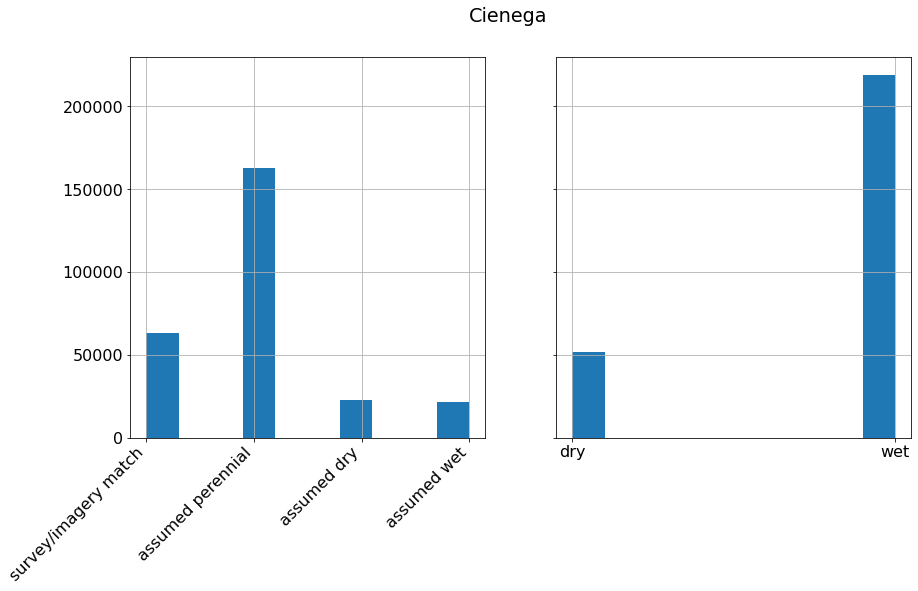

In [222]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

fig,axs = plt.subplots(1,2,figsize = (14,7),sharey=True)

ax = axs[0]
merged_sorted.assumption.hist(ax=ax)
ax.set_xticklabels(merged_sorted.assumption.unique(), rotation=45, ha='right')

ax = axs[1]
merged_sorted.wetdry.hist(ax=ax)

fig.suptitle('Cienega')

In [223]:
merged_sorted[['assumption','wetdry']].plot.bar(stacked=True)

TypeError: no numeric data to plot

Text(0.5, 1.0, 'Cienega')

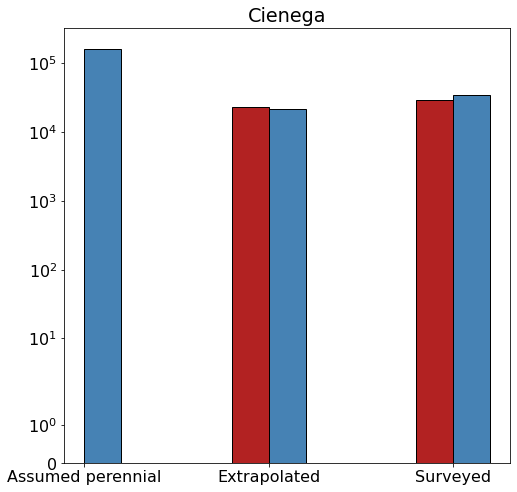

In [224]:
details = merged_sorted.groupby(['wetdry','assumption']).count()['date'].reset_index()
fig,ax = plt.subplots(1,figsize = (8,8))
ax.bar([1,2],[details.date.values[0],details.date.values[1]],width=.2,
       facecolor = 'firebrick',edgecolor = 'k')
ax.bar([.2,1.2,2.2],[details.date.values[i] for i in range(2,5)],width=.2,
       facecolor='steelblue',edgecolor = 'k')
ax.set_yscale('symlog')
ax.set_xticks([.1,1.1,2.1],['Assumed perennial','Extrapolated','Surveyed',])
ax.set_title('Cienega')

In [225]:
details

,wetdry,assumption,date
0,dry,assumed dry,22852
1,dry,survey/imagery match,29117
2,wet,assumed perennial,162884
3,wet,assumed wet,21637
4,wet,survey/imagery match,34267
